# Book-Oracle

Book-Oracle is a book recommendation apps which suggest books based on preferences.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

#modelling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
#from transformers import pipeline
#from tqdm import tqdm
#import nltk


#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

## Import Data

In [5]:
# Import data for ratings csv file
df_ratings = pd.read_csv("data/Ratings.csv")

In [6]:
#Checking no of rows and columns in dataframe
df_ratings.shape

(1149780, 3)

In [7]:
#Descriptive Stats 
df_ratings.describe()

,User-ID,Book-Rating
count,"1,149,780.00","1,149,780.00"
mean,"140,386.40",2.87
std,"80,562.28",3.85
min,2.00,0.00
25%,"70,345.00",0.00
50%,"141,010.00",0.00
75%,"211,028.00",7.00
max,"278,854.00",10.00


In [8]:
#Checking datatypes of columns in ratings dataframe
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


(ISBN) is a 13-digit number that uniquely identifies books and book-like products published internationally.

In [9]:
#Checking the string length of ISBN cell values
ISBNCount = df_ratings['ISBN'].str.len()
print(ISBNCount)

0          10
1          10
2          10
3          10
4          10
           ..
1149775    10
1149776    10
1149777    10
1149778    10
1149779    11
Name: ISBN, Length: 1149780, dtype: int64


In [10]:
# There are 7 unique ISBN values
ISBNCount.unique()

array([10,  9, 11,  8, 12, 13, 14])

In [11]:
#Total rows with All ISBN's = 1149780
#Count of ISBN's with str(len) as 13 = 1740
#Count of ISBN's with str(len) as 10 = 1139363
#Count of ISBN's with str(len) as 9 = 5140
df_13 = df_ratings[df_ratings['ISBN'].str.len()==9]

In [12]:
df_ratings.duplicated().sum()

0

In [13]:
print(df_ratings['User-ID'].nunique()) #105283
print(df_ratings['ISBN'].nunique()) #340556

105283
340556


In [14]:
# Get count duplicates multiple columns using dataframe.pivot_table() 

#Here one User-ID has given ratings for MORE than ONE ISBN(book)

df2 = df_ratings.pivot_table(index = ['User-ID', 'ISBN'], aggfunc ='size')
print(df2)

User-ID  ISBN      
2        0195153448    1
7        034542252     1
8        0002005018    1
         0060973129    1
         0374157065    1
                      ..
278854   0425163393    1
         0515087122    1
         0553275739    1
         0553578596    1
         0553579606    1
Length: 1149780, dtype: int64


NOTE : One User can rate multiple books (ISBN) likewise a Book(ISBN) can have ratings from multiple Users

Its M-M relationship


So there are NO duplicate entries in Ratings table

In [15]:
#Get Count Duplicates for Each Unique Row

df2 = df_ratings.groupby(df_ratings.columns.tolist(), as_index=False).size()

#There are NO duplicates for unique combination of User-ID and ISBN
print(df2[df2['size'] > 1])


Empty DataFrame
Columns: [User-ID, ISBN, Book-Rating, size]
Index: []


In [16]:
#check if one ISBN has multiple UserID's

isbn_counts = df_ratings.groupby('ISBN').size()

# Filter ISBNs with multiple UserIDs
multiple_userids_isbn = isbn_counts[isbn_counts > 1]

# Display ISBNs with multiple UserIDs
print(multiple_userids_isbn)



ISBN
 0330299891       2
 0375404120       2
 9022906116       2
*0452281903       2
+0451197399       2
                 ..
XXXXXXXXXX        2
ZR903CX0003       3
\0432534220\""    3
\2842053052\""    2
`3502103682       2
Length: 143511, dtype: int64


In [17]:
#Rename column names

column_name_mapping = {
    'User-ID': 'user_id',
    'Book-Rating': 'book_rating',
    # Add more mappings as needed
}

# Use the rename method to rename the columns
df_ratings.rename(columns=column_name_mapping, inplace=True)

Python function for data cleaning of Ratings csv file

- Renaming Columns
- Checking for duplicates if any
- Checking missing / null values

In [18]:
#Perform data cleaning operations on a DataFrame using pandas built-in functions.

def dataclean_rating(df_ratings):
    
    # Rename columns
    column_name_mapping = {
    'User-ID': 'user_id',
    'Book-Rating': 'book_rating',
    # Add more mappings as needed
}
# Use the rename method to rename the columns
    df_ratings.rename(columns=column_name_mapping, inplace=True)
    print(df_ratings.columns)

    # Check for and display duplicate rows
    duplicate_rows = df_ratings[df_ratings.duplicated(keep=False)]
    print("Duplicate Rows:")
    print(duplicate_rows)

    # Check for and display rows with missing values
    missing_values = df_ratings[df_ratings.isna().any(axis=1)]
    print("\nRows with Missing Values:")
    print(missing_values)

    return df_ratings

In [19]:
dataclean_rating(df_ratings)

Index(['user_id', 'ISBN', 'book_rating'], dtype='object')
Duplicate Rows:
Empty DataFrame
Columns: [user_id, ISBN, book_rating]
Index: []

Rows with Missing Values:
Empty DataFrame
Columns: [user_id, ISBN, book_rating]
Index: []


,user_id,ISBN,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


## Data Cleaning for Each Table

## Exploratory Data Analysis for Each Table

### Statistical Summary

In [24]:
df_ratings.describe(include='all')

,user_id,ISBN,book_rating
count,"1,149,780.00",1149780,"1,149,780.00"
unique,NaN,340556,NaN
top,NaN,0971880107,NaN
freq,NaN,2502,NaN
mean,"140,386.40",NaN,2.87
std,"80,562.28",NaN,3.85
min,2.00,NaN,0.00
25%,"70,345.00",NaN,0.00
50%,"141,010.00",NaN,0.00
75%,"211,028.00",NaN,7.00


- Data Visulation based on book ratings ( 0 rating included)

<Axes: xlabel='book_rating', ylabel='count'>

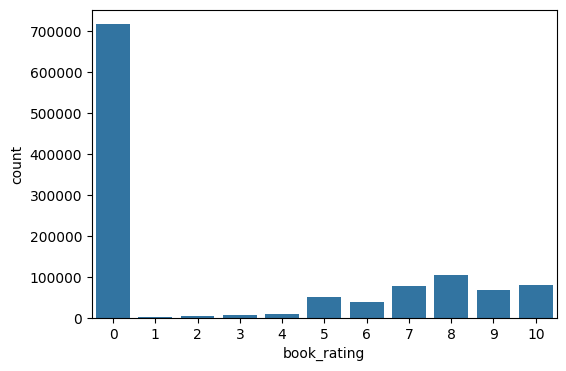

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(x="book_rating", data=df_ratings)

Text(0.5, 1.0, 'Explicit Ratings')

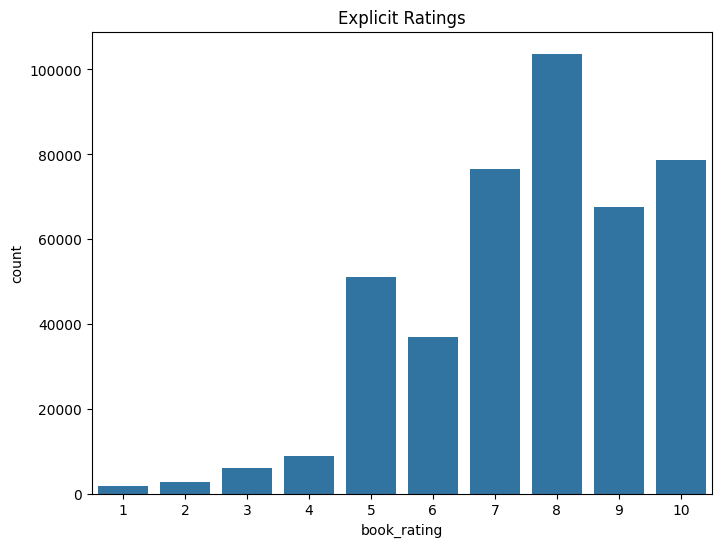

In [26]:
## Explicit Ratings (Excluded rating 0 for better visualization)
plt.figure(figsize=(8,6))
data = df_ratings[df_ratings['book_rating'] != 0]
sns.countplot(x="book_rating", data=data)
plt.title("Explicit Ratings")

In [27]:
#Description of book rating
df_ratings['book_rating'].describe()

count   1,149,780.00
mean            2.87
std             3.85
min             0.00
25%             0.00
50%             0.00
75%             7.00
max            10.00
Name: book_rating, dtype: float64

### Observation - Book-Ratings are  distributed with median rating of 3

<Figure size 1300x1700 with 0 Axes>

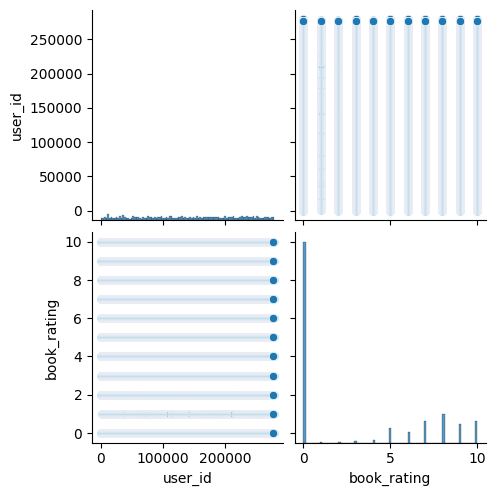

In [28]:
plt.figure(figsize=(13,17))
sns.pairplot(data=df_ratings.drop(['ISBN'],axis=1))
plt.show()

In [20]:
#Selecting Books with Optimum Number of Ratings (>5)

# counting the ratings >=5 by grouping ISBN and sort by ratings in desc order
isbn_rating_desc = df_ratings[df_ratings['book_rating'] >= 5].groupby(['ISBN'])['book_rating'].count().reset_index().sort_values('book_rating', ascending=False)
print(isbn_rating_desc)

              ISBN  book_rating
25604   0316666343          692
43584   0385504209          475
21743   0312195516          369
87590   0679781587          329
5113    0060928336          312
...            ...          ...
75425   059025507X            1
75422   0590254812            1
75421   0590254804            1
75420   0590254790            1
179375   Ô½crosoft            1

[179376 rows x 2 columns]


In [21]:
# Import data for books csv file
df_books = pd.read_csv("data/Books.csv")
df_merge = pd.merge(isbn_rating_desc.head(20), df_books, on="ISBN" )

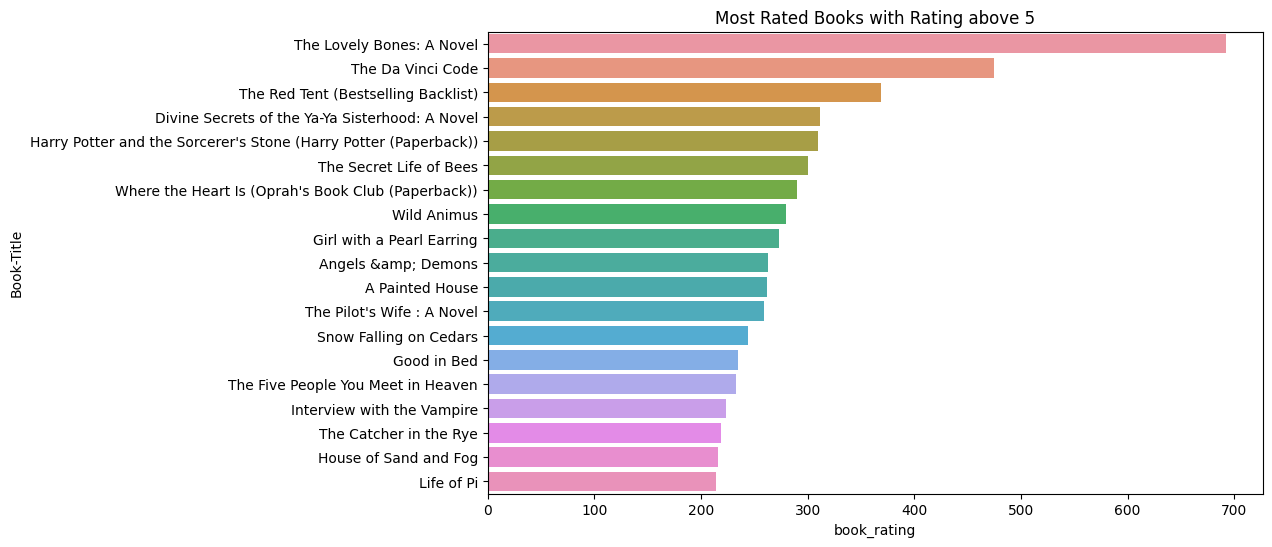

In [22]:
#Visualise most rated books with rating above 5

plt.figure(figsize=(10,6))
sns.barplot(x='book_rating', y='Book-Title', data=df_merge)
plt.title("Most Rated Books with Rating above 5")
plt.show()


In [2]:
# Convert 'ISBN' to category type for better visualization
df_ratings['ISBN'] = df_ratings['ISBN'].astype('category')

# Create a pair plot
sns.pairplot(df_ratings, hue='ISBN', markers='o', palette='viridis')

plt.show()

NameError: name 'df_ratings' is not defined

## Merge Tables

## Data Cleaning

## Exploratory Data Analysis

## Pipline Architecture

## Sample Size

## Modelling

## Evaluation

## Error Analysis